In [3]:
def trade(usdt_pool: float, mind_pool: float, fee: float, trade_amount: float, is_buy: bool) -> float:
    k = usdt_pool * mind_pool
    if is_buy:
        new_usdt_pool = usdt_pool + trade_amount * (1 - fee)
        new_mind_pool = k / new_usdt_pool
        mind_bought = mind_pool - new_mind_pool
        return mind_bought
    else:
        new_mind_pool = mind_pool + trade_amount * (1 - fee)
        new_usdt_pool = k / new_mind_pool
        usdt_bought = usdt_pool - new_usdt_pool
        return usdt_bought


In [4]:
def calculate_new_price(x, y, r, b, s, t, K, M):
    """
    Calculate new price using the formula:

    p_new = x_final / y_final

    Parameters:
    -----------
    x : float
        USDT in pool
    y : float
        MIND tokens in pool
    r : float
        Fee rate (e.g., 0.003 for 0.3%)
    b : float
        Buyback dollars per day
    s : float
        Speculative buy pressure dollars per day
    t : float
        Speculative sell pressure dollars per day
    K : float
        Miner tokens sold per day
    M : float
        Miner tokens staked (locked) per day

    Returns:
    --------
    float
        New price (USDT per MIND token)
    """
    # Net dollar flow
    net_dollar_flow = b + s - t

    # Net token flow (K tokens sold minus M tokens staked)
    net_token_flow = K - M

    # Calculate y_final (denominator)
    denominator_part = (y * r * net_dollar_flow) / (x + r * net_dollar_flow)
    y_final = y - denominator_part + r * net_token_flow

    # Calculate x_final (numerator)
    x_adjustment = ((x + net_dollar_flow) * r * net_token_flow) / y_final
    x_final = x + net_dollar_flow - x_adjustment

    # Calculate new price
    p_new = x_final / y_final

    return p_new

In [5]:
# Example usage
if __name__ == "__main__":
    # Initial pool state
    x = 300_000  # 300k USDT
    y = 300_000  # 300k MIND tokens
    r = 0.003    # 0.3% fee
    
    # Daily flows
    b = 5_000    # $5k buybacks
    s = 10_000   # $10k speculative buying
    t = 8_000    # $8k speculative selling
    K = 5_000    # 5k tokens sold by miners
    M = 7_000    # 7k tokens staked by miners
    
    # Calculate new price
    new_price = calculate_new_price(x, y, r, b, s, t, K, M)
    
    print(f"Initial price: ${x/y:.4f}")
    print(f"New price: ${new_price:.4f}")
    print(f"Price change: {(new_price/(x/y) - 1)*100:.2f}%")

Initial price: $1.0000
New price: $1.0234
Price change: 2.34%


Data that we need an idea of.

For buybacks: How much we make in a day?
Speculative buying; This probably starts high and goes lower over time, but very hard to model
Speculative selling; Similar to the above but likley goes in the other direction
Tokens sold by miners: Inflation rate and a guess of the amount that is sold in percentage, also old miners selling and leaving
Tokens bought by miners: Miners buying to stake


Assumptions; 500 bought a day  
10k tokens staked to mine  
Miner every 10 days comes online  
Miner leaves every 20 days  
1k tokens given to miners a day  
Half of those are sold, half are kept  

In [6]:
b = 500
s = 0
t = 0
K = 1_000 * 0.5 + 10_000 * 0.05 # 1k tokens given out, half sold
M = 10_000 * 0.1 # 10k tokens staked to mine, new miner every 10 days

In [7]:
new_price = calculate_new_price(x, y, r, b, s, t, K, M)

print(f"Initial price: ${x/y:.4f}")
print(f"New price: ${new_price:.4f}")
print(f"Price change: {(new_price/(x/y) - 1)*100:.2f}%")


Initial price: $1.0000
New price: $1.0017
Price change: 0.17%


## Time-Series Simulation with Halving Schedule

Now let's model the full dynamics over time with:
- Bitcoin-style halving every 4 years
- Buyback flywheel (revenue → USDC buybacks)
- Dynamic miner participation based on profitability
- Evolving token supply and inflation rate

In [8]:
import pandas as pd
import numpy as np
from dataclasses import dataclass
from typing import List

@dataclass
class SimulationConfig:
    """Configuration for tokenomics simulation"""
    # Pool setup
    initial_usdt_pool: float = 300_000
    initial_mind_pool: float = 300_000
    fee_rate: float = 0.003
    
    # Emissions schedule (halving)
    initial_daily_emission: float = 22_245  # Epoch 1
    halving_days: int = 4 * 365  # 4 years
    
    # Revenue and buybacks
    daily_revenue_usdc: float = 5_000  # Daily compute revenue
    buyback_percentage: float = 1.0  # 100% of revenue → buybacks
    
    # Miner economics
    miner_stake_amount: float = 10_000  # Tokens to stake per miner
    miner_entry_interval: int = 10  # New miner every N days
    miner_exit_interval: int = 20  # Miner leaves after N days
    miner_hardware_cost_daily: float = 50  # Daily cost in USDC
    
    # Behavior parameters
    base_miner_sell_ratio: float = 0.5  # Base % of rewards sold
    high_price_sell_ratio: float = 0.8  # Sell more when profitable
    low_price_sell_ratio: float = 0.3  # Hold more when unprofitable
    
    # Simulation
    simulation_days: int = 365 * 8  # 8 years

@dataclass
class MinerCohort:
    """Represents a group of miners that entered together"""
    entry_day: int
    exit_day: int
    stake_amount: float
    entry_price: float
    
class TokenomicsSimulation:
    def __init__(self, config: SimulationConfig):
        self.config = config
        self.reset()
    
    def reset(self):
        """Reset simulation state"""
        self.day = 0
        self.usdt_pool = self.config.initial_usdt_pool
        self.mind_pool = self.config.initial_mind_pool
        self.total_supply = self.config.initial_mind_pool  # Start with pool tokens
        self.miner_cohorts: List[MinerCohort] = []
        self.history = []
    
    def get_current_emission(self) -> float:
        """Calculate daily emission based on halving schedule"""
        epoch = self.day // self.config.halving_days
        return self.config.initial_daily_emission / (2 ** epoch)
    
    def get_current_price(self) -> float:
        """Current USDT per MIND token"""
        return self.usdt_pool / self.mind_pool
    
    def get_active_miners_stake(self) -> float:
        """Total tokens staked by active miners"""
        return sum(c.stake_amount for c in self.miner_cohorts)
    
    def calculate_miner_sell_ratio(self, current_price: float, entry_price: float) -> float:
        """Dynamic sell ratio based on profitability"""
        if current_price > entry_price * 1.5:
            return self.config.high_price_sell_ratio
        elif current_price < entry_price * 0.8:
            return self.config.low_price_sell_ratio
        else:
            return self.config.base_miner_sell_ratio
    
    def execute_trade(self, usdt_amount: float = None, mind_amount: float = None):
        """Execute a trade using constant product AMM"""
        k = self.usdt_pool * self.mind_pool
        
        if usdt_amount is not None:  # Buy MIND with USDT
            usdt_after_fee = usdt_amount * (1 - self.config.fee_rate)
            new_usdt_pool = self.usdt_pool + usdt_after_fee
            new_mind_pool = k / new_usdt_pool
            mind_received = self.mind_pool - new_mind_pool
            
            self.usdt_pool = new_usdt_pool
            self.mind_pool = new_mind_pool
            return mind_received
        
        elif mind_amount is not None:  # Sell MIND for USDT
            mind_after_fee = mind_amount * (1 - self.config.fee_rate)
            new_mind_pool = self.mind_pool + mind_after_fee
            new_usdt_pool = k / new_mind_pool
            usdt_received = self.usdt_pool - new_usdt_pool
            
            self.usdt_pool = new_usdt_pool
            self.mind_pool = new_mind_pool
            return usdt_received
    
    def simulate_day(self):
        """Simulate one day of activity"""
        current_price = self.get_current_price()
        daily_emission = self.get_current_emission()
        
        # 1. Buybacks (revenue → buy MIND)
        buyback_usdt = self.config.daily_revenue_usdc * self.config.buyback_percentage
        mind_bought = self.execute_trade(usdt_amount=buyback_usdt)
        
        # 2. Miner entry/exit
        # New miner joins
        if self.day % self.config.miner_entry_interval == 0 and self.day > 0:
            new_cohort = MinerCohort(
                entry_day=self.day,
                exit_day=self.day + self.config.miner_exit_interval,
                stake_amount=self.config.miner_stake_amount,
                entry_price=current_price
            )
            self.miner_cohorts.append(new_cohort)
            # Miner buys tokens to stake
            self.execute_trade(usdt_amount=self.config.miner_stake_amount * current_price)
        
        # Remove exiting miners
        exiting_miners = [c for c in self.miner_cohorts if c.exit_day == self.day]
        for cohort in exiting_miners:
            # Miner unstakes and sells
            self.execute_trade(mind_amount=cohort.stake_amount)
            self.miner_cohorts.remove(cohort)
        
        # 3. Miner rewards and selling
        active_miners = len(self.miner_cohorts)
        if active_miners > 0:
            reward_per_miner = daily_emission / active_miners
            
            # Calculate weighted average entry price for sell ratio
            total_stake = self.get_active_miners_stake()
            avg_entry_price = sum(c.entry_price * c.stake_amount for c in self.miner_cohorts) / total_stake if total_stake > 0 else current_price
            
            sell_ratio = self.calculate_miner_sell_ratio(current_price, avg_entry_price)
            tokens_sold_by_miners = daily_emission * sell_ratio
            
            # Miners sell their portion
            if tokens_sold_by_miners > 0:
                self.execute_trade(mind_amount=tokens_sold_by_miners)
        else:
            tokens_sold_by_miners = 0
        
        # 4. Update supply
        self.total_supply += daily_emission
        
        # 5. Calculate metrics
        new_price = self.get_current_price()
        inflation_rate = (daily_emission / self.total_supply) * 365 * 100  # Annualized %
        
        # Record history
        self.history.append({
            'day': self.day,
            'price': new_price,
            'usdt_pool': self.usdt_pool,
            'mind_pool': self.mind_pool,
            'total_supply': self.total_supply,
            'daily_emission': daily_emission,
            'inflation_rate': inflation_rate,
            'active_miners': active_miners,
            'staked_tokens': self.get_active_miners_stake(),
            'buyback_usdt': buyback_usdt,
            'mind_bought_back': mind_bought,
            'tokens_sold_by_miners': tokens_sold_by_miners,
            'epoch': self.day // self.config.halving_days
        })
        
        self.day += 1
    
    def run(self):
        """Run full simulation"""
        for _ in range(self.config.simulation_days):
            self.simulate_day()
        return pd.DataFrame(self.history)

# Create and run simulation
config = SimulationConfig()
sim = TokenomicsSimulation(config)
df = sim.run()

print(f"Simulation complete: {len(df)} days")
print(f"\nInitial state:")
print(f"  Price: ${df.iloc[0]['price']:.4f}")
print(f"  Supply: {df.iloc[0]['total_supply']:,.0f} MIND")
print(f"\nFinal state (Day {len(df)}):")
print(f"  Price: ${df.iloc[-1]['price']:.4f}")
print(f"  Supply: {df.iloc[-1]['total_supply']:,.0f} MIND")
print(f"  Inflation rate: {df.iloc[-1]['inflation_rate']:.2f}% annual")
print(f"  Price change: {(df.iloc[-1]['price']/df.iloc[0]['price'] - 1)*100:.2f}%")

Simulation complete: 2920 days

Initial state:
  Price: $1.0335
  Supply: 322,245 MIND

Final state (Day 2920):
  Price: $0.8749
  Supply: 49,016,550 MIND
  Inflation rate: 8.28% annual
  Price change: -15.34%


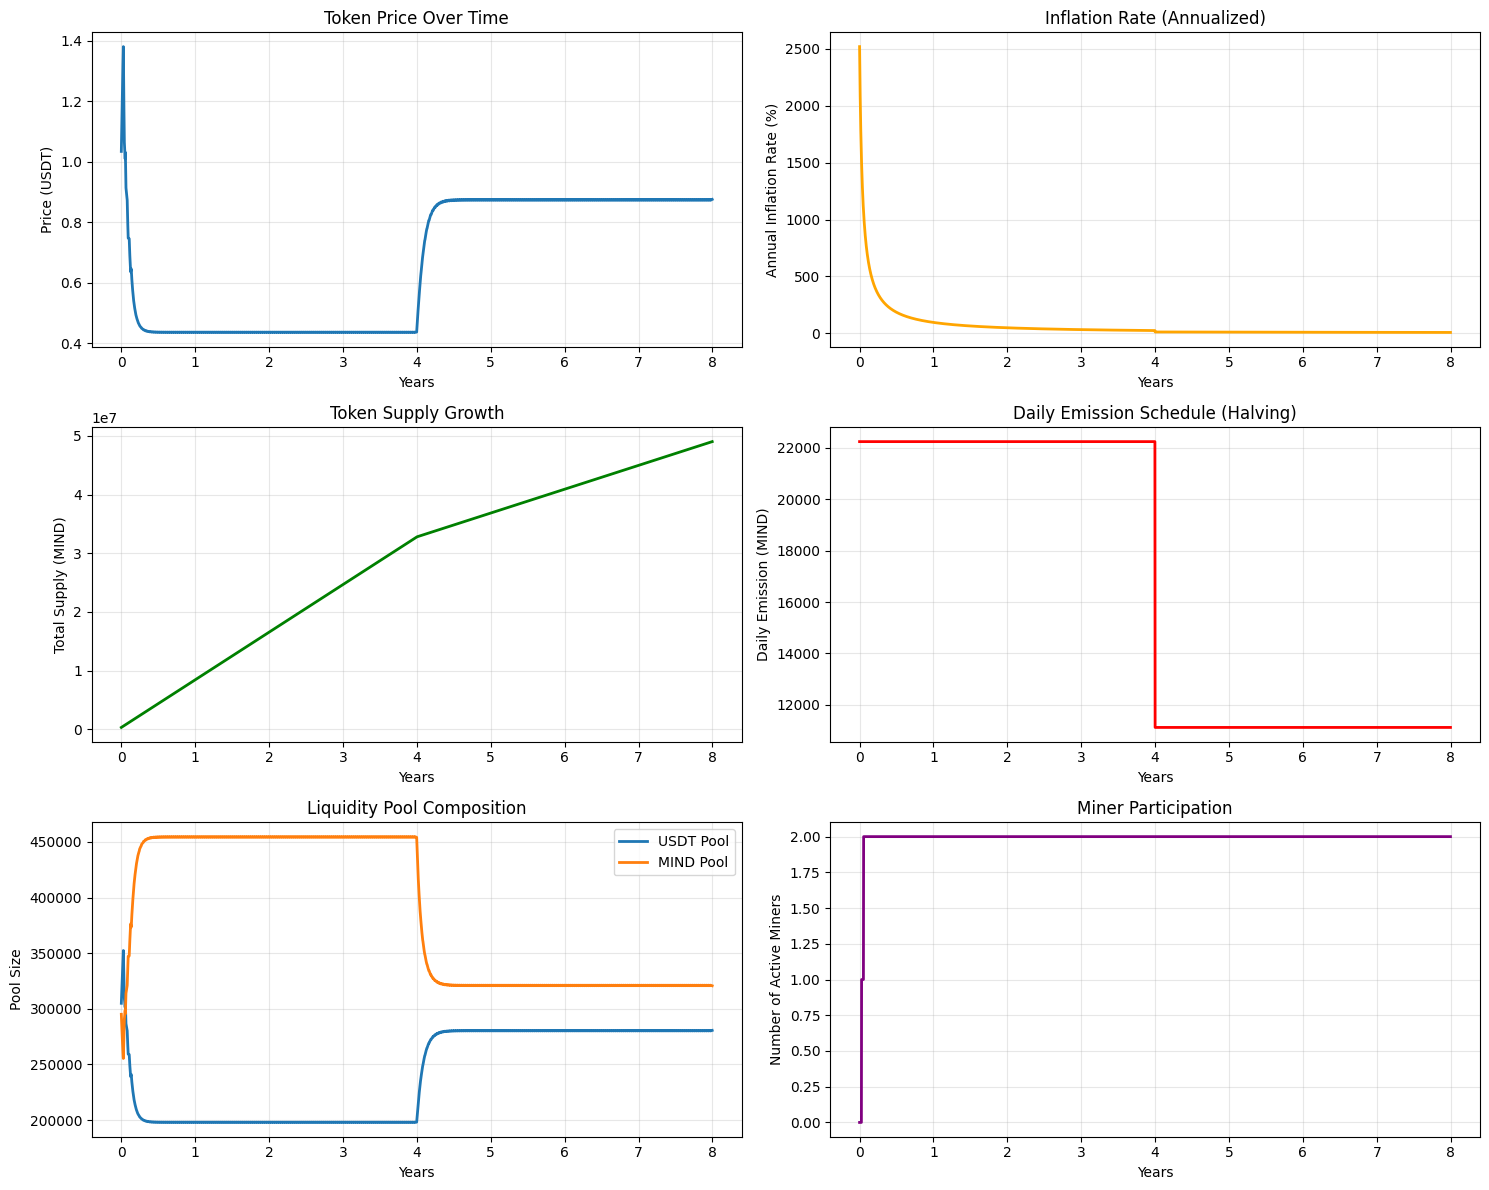

In [9]:
# Visualize key metrics over time
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 2, figsize=(15, 12))

# Price evolution
axes[0, 0].plot(df['day']/365, df['price'], linewidth=2)
axes[0, 0].set_xlabel('Years')
axes[0, 0].set_ylabel('Price (USDT)')
axes[0, 0].set_title('Token Price Over Time')
axes[0, 0].grid(True, alpha=0.3)

# Inflation rate
axes[0, 1].plot(df['day']/365, df['inflation_rate'], linewidth=2, color='orange')
axes[0, 1].set_xlabel('Years')
axes[0, 1].set_ylabel('Annual Inflation Rate (%)')
axes[0, 1].set_title('Inflation Rate (Annualized)')
axes[0, 1].grid(True, alpha=0.3)

# Total supply
axes[1, 0].plot(df['day']/365, df['total_supply'], linewidth=2, color='green')
axes[1, 0].set_xlabel('Years')
axes[1, 0].set_ylabel('Total Supply (MIND)')
axes[1, 0].set_title('Token Supply Growth')
axes[1, 0].grid(True, alpha=0.3)

# Daily emission (halving visible)
axes[1, 1].plot(df['day']/365, df['daily_emission'], linewidth=2, color='red')
axes[1, 1].set_xlabel('Years')
axes[1, 1].set_ylabel('Daily Emission (MIND)')
axes[1, 1].set_title('Daily Emission Schedule (Halving)')
axes[1, 1].grid(True, alpha=0.3)

# Pool liquidity
axes[2, 0].plot(df['day']/365, df['usdt_pool'], label='USDT Pool', linewidth=2)
axes[2, 0].plot(df['day']/365, df['mind_pool'], label='MIND Pool', linewidth=2)
axes[2, 0].set_xlabel('Years')
axes[2, 0].set_ylabel('Pool Size')
axes[2, 0].set_title('Liquidity Pool Composition')
axes[2, 0].legend()
axes[2, 0].grid(True, alpha=0.3)

# Active miners
axes[2, 1].plot(df['day']/365, df['active_miners'], linewidth=2, color='purple')
axes[2, 1].set_xlabel('Years')
axes[2, 1].set_ylabel('Number of Active Miners')
axes[2, 1].set_title('Miner Participation')
axes[2, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [10]:
# Analyze by epoch
epoch_summary = df.groupby('epoch').agg({
    'day': ['min', 'max'],
    'price': ['first', 'last', 'mean'],
    'daily_emission': 'mean',
    'inflation_rate': 'mean',
    'total_supply': 'last'
}).round(2)

print("\nEpoch Analysis:")
print(epoch_summary)


Epoch Analysis:
        day       price             daily_emission inflation_rate total_supply
        min   max first  last  mean           mean           mean         last
epoch                                                                         
0         0  1459  1.03  0.44  0.46        22245.0         116.44   32777700.0
1      1460  2919  0.45  0.87  0.86        11122.5          10.06   49016550.0


## Sensitivity Analysis

Now let's test different scenarios:

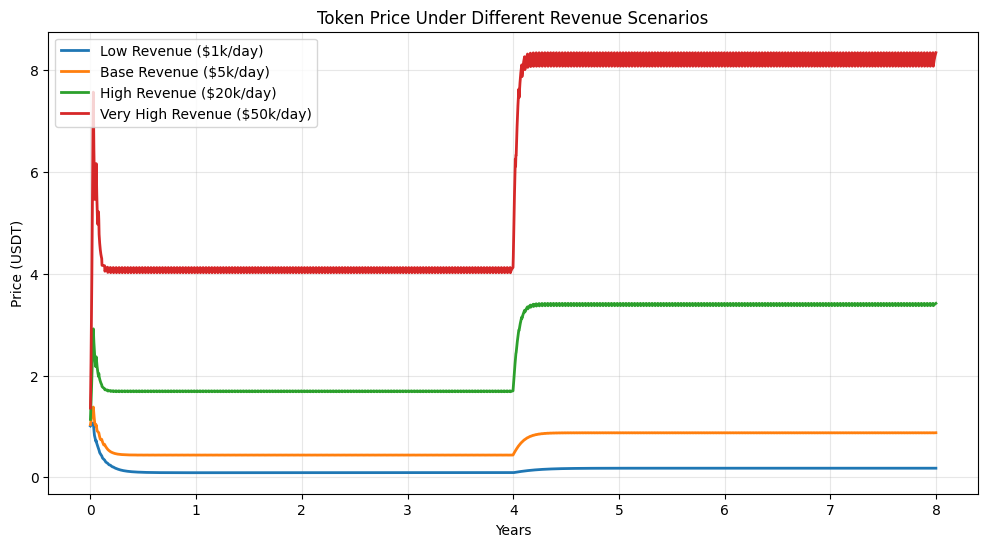


Scenario Outcomes (After 8 years):

Low Revenue ($1k/day):
  Final Price: $0.1775
  Price Change: -82.4%
  Total Supply: 49,016,550 MIND
  Inflation Rate: 8.28% annual

Base Revenue ($5k/day):
  Final Price: $0.8749
  Price Change: -15.3%
  Total Supply: 49,016,550 MIND
  Inflation Rate: 8.28% annual

High Revenue ($20k/day):
  Final Price: $3.4188
  Price Change: +200.6%
  Total Supply: 49,016,550 MIND
  Inflation Rate: 8.28% annual

Very High Revenue ($50k/day):
  Final Price: $8.3468
  Price Change: +513.8%
  Total Supply: 49,016,550 MIND
  Inflation Rate: 8.28% annual


In [11]:
# Compare different revenue scenarios
scenarios = {
    'Low Revenue ($1k/day)': {'daily_revenue_usdc': 1_000},
    'Base Revenue ($5k/day)': {'daily_revenue_usdc': 5_000},
    'High Revenue ($20k/day)': {'daily_revenue_usdc': 20_000},
    'Very High Revenue ($50k/day)': {'daily_revenue_usdc': 50_000},
}

results = {}
for name, params in scenarios.items():
    config = SimulationConfig(**params)
    sim = TokenomicsSimulation(config)
    results[name] = sim.run()

# Plot price comparison
plt.figure(figsize=(12, 6))
for name, df_scenario in results.items():
    plt.plot(df_scenario['day']/365, df_scenario['price'], label=name, linewidth=2)

plt.xlabel('Years')
plt.ylabel('Price (USDT)')
plt.title('Token Price Under Different Revenue Scenarios')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Print final outcomes
print("\nScenario Outcomes (After 8 years):")
for name, df_scenario in results.items():
    final = df_scenario.iloc[-1]
    print(f"\n{name}:")
    print(f"  Final Price: ${final['price']:.4f}")
    print(f"  Price Change: {(final['price']/df_scenario.iloc[0]['price'] - 1)*100:+.1f}%")
    print(f"  Total Supply: {final['total_supply']:,.0f} MIND")
    print(f"  Inflation Rate: {final['inflation_rate']:.2f}% annual")

In [ ]:
# Add this new cell after the sensitivity analysis

# ## Reverse Engineering Tokenomics
# 
# Let's work backwards from desired outcomes to find optimal parameters

import matplotlib.pyplot as plt
import pandas as pd

class TokenomicsDesigner:
    """Design tokenomics by working backwards from targets"""
    
    def __init__(self):
        self.results = []
    
    def calculate_required_emissions(self,
                                     target_fdv: float,
                                     target_price: float,
                                     miner_daily_cost: float,
                                     desired_miner_roi: float = 2.0):
        """
        Calculate required emission rate to sustain miners
        
        Parameters:
        -----------
        target_fdv : float
            Target fully diluted valuation (e.g., $100M)
        target_price : float
            Target token price (e.g., $1.00)
        miner_daily_cost : float
            Daily cost to run a miner (hardware + electricity)
        desired_miner_roi : float
            Multiple of cost that miners should earn (e.g., 2.0 = 2x cost)
        """
        # Total supply needed for target FDV
        total_supply = target_fdv / target_price
        
        # Daily rewards per miner needed for profitability
        daily_rewards_usd = miner_daily_cost * desired_miner_roi
        daily_rewards_tokens = daily_rewards_usd / target_price
        
        return {
            'total_supply': total_supply,
            'daily_rewards_per_miner': daily_rewards_tokens,
            'target_price': target_price,
            'target_fdv': target_fdv
        }
    
    def find_optimal_initial_liquidity(self,
                                       target_price: float,
                                       daily_buyback_usd: float,
                                       daily_sell_pressure_tokens: float,
                                       desired_slippage: float = 0.05):
        """
        Find optimal initial pool size to maintain price stability
        
        Parameters:
        -----------
        target_price : float
            Target token price
        daily_buyback_usd : float
            Daily buyback amount in USD
        daily_sell_pressure_tokens : float
            Daily tokens sold by miners
        desired_slippage : float
            Max acceptable slippage from trades (e.g., 0.05 = 5%)
        """
        # For constant product AMM: slippage = trade_size / pool_size
        # We want: buyback_slippage + sell_slippage < desired_slippage
        
        # Required USDT pool depth
        min_usdt_pool = daily_buyback_usd / desired_slippage
        
        # Required MIND pool depth (maintaining target price)
        min_mind_pool = min_usdt_pool / target_price
        
        return {
            'min_usdt_pool': min_usdt_pool,
            'min_mind_pool': min_mind_pool,
            'initial_mcap': min_usdt_pool  # Circulating market cap
        }
    
    def calculate_sustainable_emission_schedule(self,
                                                total_supply: float,
                                                num_miners_year1: int,
                                                daily_rewards_per_miner: float,
                                                years_to_distribute: int = 16):
        """
        Calculate emission schedule that distributes supply over time
        """
        # Year 1 daily emission
        initial_daily_emission = num_miners_year1 * daily_rewards_per_miner
        
        # Using halving schedule, calculate epochs
        epochs = []
        remaining_supply = total_supply
        current_emission = initial_daily_emission
        
        for epoch in range(years_to_distribute // 4):
            days_in_epoch = 4 * 365
            tokens_in_epoch = current_emission * days_in_epoch
            
            if tokens_in_epoch > remaining_supply:
                tokens_in_epoch = remaining_supply
                current_emission = remaining_supply / days_in_epoch
            
            epochs.append({
                'epoch': epoch,
                'years': f'{epoch*4}-{(epoch+1)*4}',
                'daily_emission': current_emission,
                'total_distributed': tokens_in_epoch,
                'pct_of_supply': tokens_in_epoch / total_supply * 100
            })
            
            remaining_supply -= tokens_in_epoch
            current_emission /= 2  # Halving
            
            if remaining_supply <= 0:
                break
        
        return pd.DataFrame(epochs)
    
    def design_scenario(self, 
                       target_fdv: float,
                       target_price: float,
                       year1_daily_revenue: float,
                       num_miners_year1: int = 50,
                       miner_daily_cost: float = 100,
                       miner_roi: float = 2.0):
        """
        Complete scenario design
        """
        print(f"\n{'='*60}")
        print(f"SCENARIO: ${target_fdv/1e6:.1f}M FDV @ ${target_price:.2f}")
        print(f"{'='*60}\n")
        
        # 1. Calculate required emissions
        emissions = self.calculate_required_emissions(
            target_fdv, target_price, miner_daily_cost, miner_roi
        )
        
        print(f"📊 Supply Design:")
        print(f"   Total Supply: {emissions['total_supply']:,.0f} MIND")
        print(f"   Daily Rewards/Miner: {emissions['daily_rewards_per_miner']:,.0f} MIND")
        print(f"   (= ${emissions['daily_rewards_per_miner'] * target_price:.2f} @ target price)")
        
        # 2. Calculate optimal liquidity
        daily_emission = emissions['daily_rewards_per_miner'] * num_miners_year1
        daily_sell_pressure = daily_emission * 0.5  # Assume 50% sold
        
        liquidity = self.find_optimal_initial_liquidity(
            target_price,
            year1_daily_revenue,
            daily_sell_pressure
        )
        
        print(f"\n💧 Initial Liquidity Pool:")
        print(f"   USDT: ${liquidity['min_usdt_pool']:,.0f}")
        print(f"   MIND: {liquidity['min_mind_pool']:,.0f}")
        print(f"   Initial Circulating: {liquidity['min_mind_pool']:,.0f} ({liquidity['min_mind_pool']/emissions['total_supply']*100:.1f}%)")
        print(f"   Circulating MCap: ${liquidity['initial_mcap']:,.0f}")
        
        # 3. Emission schedule
        schedule = self.calculate_sustainable_emission_schedule(
            emissions['total_supply'],
            num_miners_year1,
            emissions['daily_rewards_per_miner']
        )
        
        print(f"\n📅 Emission Schedule:")
        print(schedule.to_string(index=False))
        
        # 4. Check economics
        print(f"\n✅ Economic Checks:")
        buyback_support = year1_daily_revenue / target_price
        print(f"   Daily Buyback: ${year1_daily_revenue:,.0f} = {buyback_support:,.0f} MIND")
        print(f"   Daily Sell Pressure: {daily_sell_pressure:,.0f} MIND")
        print(f"   Net Daily Flow: {buyback_support - daily_sell_pressure:+,.0f} MIND")
        
        ratio = buyback_support / daily_sell_pressure
        if ratio > 1.0:
            print(f"   ✅ Net Positive (buyback {ratio:.1f}x sell pressure)")
        else:
            print(f"   ⚠️  Net Negative (buyback only {ratio:.1f}x sell pressure)")
        
        return {
            'emissions': emissions,
            'liquidity': liquidity,
            'schedule': schedule
        }

# Test different scenarios
designer = TokenomicsDesigner()

# Conservative: $50M FDV, $0.50 token
scenario_conservative = designer.design_scenario(
    target_fdv=50_000_000,
    target_price=0.50,
    year1_daily_revenue=2_000,
    num_miners_year1=30
)

# Moderate: $100M FDV, $1.00 token  
scenario_moderate = designer.design_scenario(
    target_fdv=100_000_000,
    target_price=1.00,
    year1_daily_revenue=5_000,
    num_miners_year1=50
)

# Aggressive: $500M FDV, $2.00 token
scenario_aggressive = designer.design_scenario(
    target_fdv=500_000_000,
    target_price=2.00,
    year1_daily_revenue=20_000,
    num_miners_year1=100
)

In [12]:
# Add this cell to calculate target-driven parameters

class TargetDrivenTokenomics:
    """Calculate parameters needed to hit target appreciation"""
    
    def __init__(self, 
                 total_supply: float = 100_000_000,
                 initial_fdv: float = 15_000_000,
                 target_annual_appreciation: float = 0.10):  # 10%
        
        self.total_supply = total_supply
        self.initial_fdv = initial_fdv
        self.initial_price = initial_fdv / total_supply
        self.target_appreciation = target_annual_appreciation
    
    def calculate_required_buyback_ratio(self,
                                         daily_emission: float,
                                         miner_sell_ratio: float = 0.5):
        """
        Calculate buyback needed to achieve target appreciation
        
        For price to appreciate at target rate, we need:
        Net buying pressure > Net selling pressure
        
        Simplified (assuming s=t, M=K):
        Daily buyback (tokens) = Daily emission * sell_ratio * (1 + appreciation_factor)
        """
        # Daily tokens sold by miners
        daily_sell_pressure_tokens = daily_emission * miner_sell_ratio
        
        # To achieve target appreciation, buyback must exceed sell pressure
        daily_appreciation = self.target_appreciation / 365
        
        # Required net positive flow (in tokens)
        # This is approximate - real AMM math is more complex
        required_net_tokens = (self.total_supply * daily_appreciation)
        
        # Total buyback needed (tokens)
        required_buyback_tokens = daily_sell_pressure_tokens + required_net_tokens
        
        # Convert to USD at current price
        required_buyback_usd = required_buyback_tokens * self.initial_price
        
        return {
            'daily_emission': daily_emission,
            'daily_sell_pressure_tokens': daily_sell_pressure_tokens,
            'daily_sell_pressure_usd': daily_sell_pressure_tokens * self.initial_price,
            'required_buyback_tokens': required_buyback_tokens,
            'required_buyback_usd': required_buyback_usd,
            'net_daily_flow_tokens': required_net_tokens,
            'buyback_to_emission_ratio': required_buyback_tokens / daily_emission,
        }
    
    def find_sustainable_emission(self,
                                   expected_daily_revenue: float,
                                   miner_sell_ratio: float = 0.5):
        """
        Work backwards: Given revenue, what emission rate is sustainable?
        
        If we know how much we can buyback daily,
        what's the max emission that still allows appreciation?
        """
        # Buyback capacity (in MIND tokens)
        buyback_capacity_tokens = expected_daily_revenue / self.initial_price
        
        # For target appreciation, we need:
        # buyback_tokens = emission * sell_ratio * (1 + buffer)
        
        daily_appreciation = self.target_appreciation / 365
        required_net_tokens = self.total_supply * daily_appreciation
        
        # Solve for emission:
        # buyback_tokens = emission * sell_ratio + required_net_tokens
        # emission = (buyback_tokens - required_net_tokens) / sell_ratio
        
        max_sustainable_emission = (buyback_capacity_tokens - required_net_tokens) / miner_sell_ratio
        
        # Check if this is reasonable
        annual_inflation = (max_sustainable_emission * 365 / self.total_supply) * 100
        
        return {
            'daily_revenue': expected_daily_revenue,
            'buyback_capacity_tokens': buyback_capacity_tokens,
            'max_sustainable_emission': max_sustainable_emission,
            'annual_inflation_rate': annual_inflation,
            'required_net_tokens_daily': required_net_tokens,
        }

# Initialize
tokenomics = TargetDrivenTokenomics(
    total_supply=100_000_000,
    initial_fdv=15_000_000,
    target_annual_appreciation=0.10  # 10% per year
)

print("="*70)
print(f"TARGET: {tokenomics.total_supply:,.0f} MIND @ ${tokenomics.initial_price:.4f}")
print(f"Initial FDV: ${tokenomics.initial_fdv:,.0f}")
print(f"Target Appreciation: {tokenomics.target_appreciation*100:.1f}% annually")
print("="*70)

# Scenario 1: Bitcoin-style emission (22,245/day)
print("\n📊 SCENARIO 1: BTC-style emission (22,245/day)")
result1 = tokenomics.calculate_required_buyback_ratio(
    daily_emission=22_245,
    miner_sell_ratio=0.5
)
print(f"  Daily Emission: {result1['daily_emission']:,.0f} MIND")
print(f"  Daily Sell Pressure: {result1['daily_sell_pressure_tokens']:,.0f} MIND (${result1['daily_sell_pressure_usd']:,.0f})")
print(f"  Required Buyback: {result1['required_buyback_tokens']:,.0f} MIND (${result1['required_buyback_usd']:,.0f})")
print(f"  Net Daily Accumulation: {result1['net_daily_flow_tokens']:,.0f} MIND")
print(f"  Buyback/Emission Ratio: {result1['buyback_to_emission_ratio']:.2f}x")

# Scenario 2: Work backwards from expected revenue
print("\n📊 SCENARIO 2: Revenue-Constrained ($5k/day revenue)")
result2 = tokenomics.find_sustainable_emission(
    expected_daily_revenue=5_000,
    miner_sell_ratio=0.5
)
print(f"  Daily Revenue: ${result2['daily_revenue']:,.0f}")
print(f"  Buyback Capacity: {result2['buyback_capacity_tokens']:,.0f} MIND")
print(f"  Max Sustainable Emission: {result2['max_sustainable_emission']:,.0f} MIND/day")
print(f"  Annual Inflation: {result2['annual_inflation_rate']:.2f}%")
print(f"  Daily Net Accumulation: {result2['required_net_tokens_daily']:,.0f} MIND")

# Scenario 3: More conservative revenue
print("\n📊 SCENARIO 3: Conservative ($2k/day revenue)")
result3 = tokenomics.find_sustainable_emission(
    expected_daily_revenue=2_000,
    miner_sell_ratio=0.5
)
print(f"  Daily Revenue: ${result3['daily_revenue']:,.0f}")
print(f"  Buyback Capacity: {result3['buyback_capacity_tokens']:,.0f} MIND")
print(f"  Max Sustainable Emission: {result3['max_sustainable_emission']:,.0f} MIND/day")
print(f"  Annual Inflation: {result3['annual_inflation_rate']:.2f}%")

# Scenario 4: Aggressive revenue
print("\n📊 SCENARIO 4: Aggressive ($20k/day revenue)")
result4 = tokenomics.find_sustainable_emission(
    expected_daily_revenue=20_000,
    miner_sell_ratio=0.5
)
print(f"  Daily Revenue: ${result4['daily_revenue']:,.0f}")
print(f"  Buyback Capacity: {result4['buyback_capacity_tokens']:,.0f} MIND")
print(f"  Max Sustainable Emission: {result4['max_sustainable_emission']:,.0f} MIND/day")
print(f"  Annual Inflation: {result4['annual_inflation_rate']:.2f}%")

TARGET: 100,000,000 MIND @ $0.1500
Initial FDV: $15,000,000
Target Appreciation: 10.0% annually

📊 SCENARIO 1: BTC-style emission (22,245/day)
  Daily Emission: 22,245 MIND
  Daily Sell Pressure: 11,122 MIND ($1,668)
  Required Buyback: 38,520 MIND ($5,778)
  Net Daily Accumulation: 27,397 MIND
  Buyback/Emission Ratio: 1.73x

📊 SCENARIO 2: Revenue-Constrained ($5k/day revenue)
  Daily Revenue: $5,000
  Buyback Capacity: 33,333 MIND
  Max Sustainable Emission: 11,872 MIND/day
  Annual Inflation: 4.33%
  Daily Net Accumulation: 27,397 MIND

📊 SCENARIO 3: Conservative ($2k/day revenue)
  Daily Revenue: $2,000
  Buyback Capacity: 13,333 MIND
  Max Sustainable Emission: -28,128 MIND/day
  Annual Inflation: -10.27%

📊 SCENARIO 4: Aggressive ($20k/day revenue)
  Daily Revenue: $20,000
  Buyback Capacity: 133,333 MIND
  Max Sustainable Emission: 211,872 MIND/day
  Annual Inflation: 77.33%


In [ ]:
class AMMTokenomicsCalculator:
    """Precise AMM math for tokenomics design"""
    
    def __init__(self, 
                 usdt_pool: float,
                 mind_pool: float,
                 fee_rate: float = 0.003):
        self.x = usdt_pool
        self.y = mind_pool
        self.k = usdt_pool * mind_pool
        self.fee = fee_rate
        self.current_price = usdt_pool / mind_pool
    
    def price_after_trades(self, buyback_usd: float, emission_tokens: float) -> dict:
        """
        Calculate exact price after buyback and emission selling
        
        Math:
        1. Buyback: x₁ = x + b(1-f), y₁ = k/x₁
        2. Sell: y₂ = y₁ + e(1-f), x₂ = k/y₂
        3. Final price: p_new = x₂/y₂
        """
        # Step 1: Buyback (buy MIND with USDT)
        x1 = self.x + buyback_usd * (1 - self.fee)
        y1 = self.k / x1
        
        # Step 2: Emission selling (sell MIND for USDT)
        y2 = y1 + emission_tokens * (1 - self.fee)
        x2 = self.k / y2
        
        # Final price
        p_new = x2 / y2
        
        # Calculate percentage change
        price_change = (p_new / self.current_price - 1)
        
        return {
            'initial_price': self.current_price,
            'final_price': p_new,
            'price_change_pct': price_change * 100,
            'x_final': x2,
            'y_final': y2,
            'mind_bought': self.y - y1,
            'usdt_from_selling': x1 - x2
        }
    
    def find_buyback_for_target_appreciation(self,
                                             emission_tokens: float,
                                             target_annual_appreciation: float,
                                             max_iterations: int = 100,
                                             tolerance: float = 1e-6) -> dict:
        """
        Binary search to find exact buyback needed for target appreciation
        
        We want: p_new = p * (1 + r/365)^(1/365) for daily compounding
        
        Where p_new = x₂/y₂ after both buyback and selling
        """
        # Use compound interest formula for daily compounding
        target_daily_appreciation = (1 + target_annual_appreciation) ** (1/365) - 1
        target_price = self.current_price * (1 + target_daily_appreciation)
        
        # Binary search bounds
        low = 0.0
        high = emission_tokens * self.current_price * 10  # Upper bound
    
        for iteration in range(max_iterations):
            mid = (low + high) / 2
            result = self.price_after_trades(mid, emission_tokens)
            
            if abs(result['final_price'] - target_price) < tolerance:
                return {
                    'required_buyback_usd': mid,
                    'target_price': target_price,
                    'achieved_price': result['final_price'],
                    'target_daily_appreciation_pct': target_daily_appreciation * 100,
                    'achieved_daily_appreciation_pct': result['price_change_pct'],
                    'annual_appreciation_compound': ((result['final_price'] / self.current_price) ** 365 - 1) * 100,
                    'emission_tokens': emission_tokens,
                    'iterations': iteration + 1
                }
            
            if result['final_price'] < target_price:
                low = mid  # Need more buyback
            else:
                high = mid  # Too much buyback
        
        # Return best approximation
        result = self.price_after_trades(mid, emission_tokens)
        return {
            'required_buyback_usd': mid,
            'target_price': target_price,
            'achieved_price': result['final_price'],
            'target_daily_appreciation_pct': target_daily_appreciation * 100,
            'achieved_daily_appreciation_pct': result['price_change_pct'],
            'annual_appreciation_compound': ((result['final_price'] / self.current_price) ** 365 - 1) * 100,
            'emission_tokens': emission_tokens,
            'iterations': max_iterations,
            'converged': False
        }
    
    def find_max_sustainable_emission(
        self,
        daily_revenue_usd: float,
        target_annual_appreciation: float,
        miner_sell_ratio: float = 0.5,
        max_iterations: int = 100,
        tolerance: float = 1.0
    ) -> dict:
        """
        Binary search to find max emission that maintains target appreciation
        
        Given: daily_revenue (buyback capacity)
        Find: max daily_emission where price still appreciates at target rate
        """
        target_daily_appreciation = target_annual_appreciation / 365
        target_price = self.current_price * (1 + target_daily_appreciation)
        
        # Binary search bounds
        low = 0.0
        high = daily_revenue_usd / (self.current_price * miner_sell_ratio) * 10
        
        best_emission = 0.0
        
        for iteration in range(max_iterations):
            mid = (low + high) / 2
            emission_sold = mid * miner_sell_ratio
            
            result = self.price_after_trades(daily_revenue_usd, emission_sold)
            
            if abs(result['final_price'] - target_price) < tolerance * self.current_price * 1e-4:
                return {
                    'max_sustainable_emission': mid,
                    'daily_revenue': daily_revenue_usd,
                    'emission_sold': emission_sold,
                    'target_price': target_price,
                    'achieved_price': result['final_price'],
                    'annual_inflation_pct': (mid * 365 / (self.y * (1 + self.x/self.current_price))) * 100,
                    'miner_sell_ratio': miner_sell_ratio,
                    'iterations': iteration + 1
                }
            
            if result['final_price'] < target_price:
                high = mid  # Emission too high, price dropped
                best_emission = mid
            else:
                low = mid  # Can support more emission
        
        # Return best approximation
        emission_sold = best_emission * miner_sell_ratio
        result = self.price_after_trades(daily_revenue_usd, emission_sold)
        
        return {
            'max_sustainable_emission': best_emission,
            'daily_revenue': daily_revenue_usd,
            'emission_sold': emission_sold,
            'target_price': target_price,
            'achieved_price': result['final_price'],
            'annual_inflation_pct': (best_emission * 365 / (self.y * (1 + self.x/self.current_price))) * 100,
            'miner_sell_ratio': miner_sell_ratio,
            'iterations': max_iterations,
            'converged': False
        }

# Initialize with your parameters
amm = AMMTokenomicsCalculator(
    usdt_pool=300_000,  # Initial USDT
    mind_pool=300_000,  # Initial MIND (starting price = $1.00)
    fee_rate=0.003
)

print("="*70)
print("PRECISE AMM CALCULATIONS")
print(f"Initial Pool: {amm.x:,.0f} USDT / {amm.y:,.0f} MIND")
print(f"Initial Price: ${amm.current_price:.4f}")
print(f"Pool Constant k: {amm.k:,.0f}")
print("="*70)

# Test 1: What buyback needed for 10% annual appreciation with 22,245 emission?
print("\n📊 TEST 1: Bitcoin-style emission (22,245/day)")
print("Target: 10% annual appreciation")

result1 = amm.find_buyback_for_target_appreciation(
    emission_tokens=22_245 * 0.5,  # Assume 50% sold
    target_annual_appreciation=0.10
)

print(f"\nDaily Emission: 22,245 MIND")
print(f"Miner Sell Ratio: 50%")
print(f"Tokens Sold: {22_245 * 0.5:,.0f} MIND")
print(f"\nRequired Daily Buyback: ${result1['required_buyback_usd']:,.2f}")
print(f"Target Daily Appreciation: {result1['target_daily_appreciation_pct']:.6f}%")
print(f"Achieved Appreciation: {result1['achieved_daily_appreciation_pct']:.6f}%")
print(f"Converged in {result1['iterations']} iterations")

# Test 2: Given $5k/day revenue, what's max sustainable emission?
print("\n" + "="*70)
print("📊 TEST 2: Revenue-Constrained Emission")
print("Given: $5,000/day revenue")
print("Target: 10% annual appreciation")

result2 = amm.find_max_sustainable_emission(
    daily_revenue_usd=5_000,
    target_annual_appreciation=0.10,
    miner_sell_ratio=0.5
)

print(f"\nMax Sustainable Emission: {result2['max_sustainable_emission']:,.0f} MIND/day")
print(f"Tokens Sold (50%): {result2['emission_sold']:,.0f} MIND")
print(f"Annual Inflation Rate: {result2['annual_inflation_pct']:.2f}%")
print(f"Target Price: ${result2['target_price']:.4f}")
print(f"Achieved Price: ${result2['achieved_price']:.4f}")

# Test 3: Different revenue scenarios
print("\n" + "="*70)
print("📊 TEST 3: Revenue Scenario Analysis")
print("="*70)

scenarios = [
    ("Conservative", 2_000),
    ("Moderate", 5_000),
    ("Aggressive", 10_000),
    ("Very Aggressive", 20_000),
]

for name, revenue in scenarios:
    result = amm.find_max_sustainable_emission(
        daily_revenue_usd=revenue,
        target_annual_appreciation=0.10,
        miner_sell_ratio=0.5
    )
    
    print(f"\n{name}: ${revenue:,}/day revenue")
    print(f"  Max Emission: {result['max_sustainable_emission']:,.0f} MIND/day")
    print(f"  Annual Inflation: {result['annual_inflation_pct']:.2f}%")
    print(f"  New Price: ${result['achieved_price']:.4f}")

# Test 4: Show the math step-by-step for one example
print("\n" + "="*70)
print("📊 TEST 4: Step-by-Step AMM Math")
print("="*70)
print("\nScenario: $5k buyback, 10k MIND emission sold")

detailed = amm.price_after_trades(
    buyback_usd=5_000,
    emission_tokens=10_000
)

print(f"\nInitial State:")
print(f"  x (USDT pool): {amm.x:,.0f}")
print(f"  y (MIND pool): {amm.y:,.0f}")
print(f"  k = x * y: {amm.k:,.0f}")
print(f"  Price: ${detailed['initial_price']:.4f}")

print(f"\nStep 1: Buyback (buy MIND with $5,000 USDT)")
x1 = amm.x + 5_000 * (1 - amm.fee)
y1 = amm.k / x1
print(f"  x₁ = {amm.x:,.0f} + 5000*(1-0.003) = {x1:,.0f}")
print(f"  y₁ = {amm.k:,.0f} / {x1:,.0f} = {y1:,.0f}")
print(f"  MIND bought: {detailed['mind_bought']:,.2f}")
print(f"  Price after buyback: ${x1/y1:.4f}")

print(f"\nStep 2: Emission Selling (sell 10,000 MIND)")
y2 = y1 + 10_000 * (1 - amm.fee)
x2 = amm.k / y2
print(f"  y₂ = {y1:,.0f} + 10000*(1-0.003) = {y2:,.0f}")
print(f"  x₂ = {amm.k:,.0f} / {y2:,.0f} = {x2:,.0f}")
print(f"  USDT received: {detailed['usdt_from_selling']:,.2f}")

print(f"\nFinal State:")
print(f"  x (USDT pool): {detailed['x_final']:,.0f}")
print(f"  y (MIND pool): {detailed['y_final']:,.0f}")
print(f"  Final Price: ${detailed['final_price']:.4f}")
print(f"  Price Change: {detailed['price_change_pct']:+.4f}%")

PRECISE AMM CALCULATIONS
Initial Pool: 300,000 USDT / 300,000 MIND
Initial Price: $1.0000
Pool Constant k: 90,000,000,000

📊 TEST 1: Bitcoin-style emission (22,245/day)
Target: 10% annual appreciation

Daily Emission: 22,245 MIND
Miner Sell Ratio: 50%
Tokens Sold: 11,122 MIND

Required Daily Buyback: $11,593.72
Target Daily Appreciation: 0.027397%
Achieved Appreciation: 0.027314%
Converged in 18 iterations

📊 TEST 2: Revenue-Constrained Emission
Given: $5,000/day revenue
Target: 10% annual appreciation

Max Sustainable Emission: 9,766 MIND/day
Tokens Sold (50%): 4,883 MIND
Annual Inflation Rate: 0.00%
Target Price: $1.0003
Achieved Price: $1.0002

📊 TEST 3: Revenue Scenario Analysis

Conservative: $2,000/day revenue
  Max Emission: 3,906 MIND/day
  Annual Inflation: 0.00%
  New Price: $1.0002

Moderate: $5,000/day revenue
  Max Emission: 9,766 MIND/day
  Annual Inflation: 0.00%
  New Price: $1.0002

Aggressive: $10,000/day revenue
  Max Emission: 19,287 MIND/day
  Annual Inflation: 0.0

In [15]:
# ============================================================================
# PHASE-BY-PHASE ANALYSIS WITH REAL REVENUE DATA
# ============================================================================

# User-configurable parameters at the top
TARGET_ANNUAL_APPRECIATION = 0.10  # 10% per year
MINER_SELL_RATIO = 0.5  # 50% of emissions sold by miners

# Initial pool state
initial_usdt_pool = 300_000
initial_mind_pool = 300_000
initial_price = initial_usdt_pool / initial_mind_pool
fee_rate = 0.003

# Phase data from your revenue projections
phases = [
    {
        'month': 1,
        'phase': 'Testnet Pilot',
        'dau': 100,
        'prompts_per_user': 80,
        'fee_per_inference': 0.10,
        'monthly_revenue': 800
    },
    {
        'month': 2,
        'phase': 'Testnet Beta',
        'dau': 250,
        'prompts_per_user': 80,
        'fee_per_inference': 0.10,
        'monthly_revenue': 2_000
    },
    {
        'month': 3,
        'phase': 'Ecosystem Growth',
        'dau': 600,
        'prompts_per_user': 90,
        'fee_per_inference': 0.10,
        'monthly_revenue': 5_400
    },
    {
        'month': 4,
        'phase': 'Pre-TGE Warmup',
        'dau': 1_200,
        'prompts_per_user': 90,
        'fee_per_inference': 0.10,
        'monthly_revenue': 10_800
    },
    {
        'month': 5,
        'phase': 'Mainnet / TGE',
        'dau': 2_100,
        'prompts_per_user': 100,
        'fee_per_inference': 0.10,
        'monthly_revenue': 21_000
    },
    {
        'month': 6,
        'phase': 'Post-Launch',
        'dau': 3_000,
        'prompts_per_user': 100,
        'fee_per_inference': 0.10,
        'monthly_revenue': 30_000
    },
    {
        'month': 7,
        'phase': 'Agent Infrastructure',
        'dau': 4_200,
        'prompts_per_user': 110,
        'fee_per_inference': 0.12,
        'monthly_revenue': 55_440
    },
    {
        'month': 8,
        'phase': 'Model Expansion',
        'dau': 6_000,
        'prompts_per_user': 110,
        'fee_per_inference': 0.12,
        'monthly_revenue': 79_200
    },
    {
        'month': 9,
        'phase': 'Launchpad Live',
        'dau': 8_500,
        'prompts_per_user': 120,
        'fee_per_inference': 0.12,
        'monthly_revenue': 122_400
    },
    {
        'month': 10,
        'phase': 'Specialized Clusters',
        'dau': 11_000,
        'prompts_per_user': 120,
        'fee_per_inference': 0.15,
        'monthly_revenue': 198_000
    },
    {
        'month': 11,
        'phase': 'Scaling Mainstream',
        'dau': 14_000,
        'prompts_per_user': 130,
        'fee_per_inference': 0.15,
        'monthly_revenue': 273_000
    },
    {
        'month': 12,
        'phase': 'Protocol Maturity',
        'dau': 18_000,
        'prompts_per_user': 130,
        'fee_per_inference': 0.15,
        'monthly_revenue': 351_000
    }
]

print("="*80)
print("PHASE-BY-PHASE TOKENOMICS ANALYSIS")
print(f"Target Annual Appreciation: {TARGET_ANNUAL_APPRECIATION*100:.0f}%")
print(f"Miner Sell Ratio: {MINER_SELL_RATIO*100:.0f}%")
print("="*80)


for phase in phases:
    # Calculate daily revenue (monthly / 30 days)
    daily_revenue = phase['monthly_revenue'] / 30
    
    # Initialize AMM for this phase
    amm = AMMTokenomicsCalculator(
        usdt_pool=initial_usdt_pool,
        mind_pool=initial_mind_pool,
        fee_rate=fee_rate
    )
    
    # Find max sustainable emission for this revenue level
    result = amm.find_max_sustainable_emission(
        daily_revenue_usd=daily_revenue,
        target_annual_appreciation=TARGET_ANNUAL_APPRECIATION,
        miner_sell_ratio=MINER_SELL_RATIO
    )
    
    print(f"\n{'='*80}")
    print(f"MONTH {phase['month']}: {phase['phase']}")
    print(f"{'='*80}")
    
    print(f"\n📊 Business Metrics:")
    print(f"   Daily Active Users: {phase['dau']:,}")
    print(f"   Prompts/User/Month: {phase['prompts_per_user']}")
    print(f"   Fee per Inference: ${phase['fee_per_inference']:.2f}")
    print(f"   Monthly Revenue: ${phase['monthly_revenue']:,}")
    print(f"   Daily Revenue: ${daily_revenue:,.2f}")
    
    print(f"\n💰 Tokenomics Results:")
    print(f"   Max Sustainable Emission: {result['max_sustainable_emission']:,.0f} MIND/day")
    print(f"   Tokens Sold by Miners: {result['emission_sold']:,.0f} MIND/day")
    print(f"   Tokens Held by Miners: {result['max_sustainable_emission'] - result['emission_sold']:,.0f} MIND/day")
    print(f"   Annual Inflation Rate: {result['annual_inflation_pct']:.2f}%")
    
    # Calculate monthly emission
    monthly_emission = result['max_sustainable_emission'] * 30
    annual_emission = result['max_sustainable_emission'] * 365
    
    print(f"\n📅 Emission Rates:")
    print(f"   Monthly Emission: {monthly_emission:,.0f} MIND")
    print(f"   Annual Emission: {annual_emission:,.0f} MIND")
    
    # Calculate how many miners this can support
    # Assume each miner needs ~$100/day in rewards to be profitable
    daily_reward_pool_usd = result['max_sustainable_emission'] * amm.current_price
    estimated_miners = daily_reward_pool_usd / 100
    
    print(f"\n👷 Miner Economics:")
    print(f"   Daily Reward Pool: ${daily_reward_pool_usd:,.2f}")
    print(f"   Est. Miners Supported (~$100/day each): {estimated_miners:.0f}")
    print(f"   Reward per Miner: {result['max_sustainable_emission']/max(1, estimated_miners):,.0f} MIND/day")
    
    print(f"\n✅ Price Stability Check:")
    print(f"   Current Price: ${amm.current_price:.4f}")
    print(f"   Target Price (next day): ${result['target_price']:.4f}")
    print(f"   Achieved Price: ${result['achieved_price']:.4f}")
    
    # Calculate if this is net positive or negative
    buyback_tokens = daily_revenue / amm.current_price
    sell_pressure_tokens = result['emission_sold']
    net_flow = buyback_tokens - sell_pressure_tokens
    
    print(f"\n🔄 Daily Token Flows:")
    print(f"   Buyback Pressure: {buyback_tokens:,.0f} MIND (${daily_revenue:,.0f})")
    print(f"   Sell Pressure: {sell_pressure_tokens:,.0f} MIND")
    print(f"   Net Flow: {net_flow:+,.0f} MIND {'✅' if net_flow > 0 else '⚠️'}")
    
    if net_flow > 0:
        ratio = buyback_tokens / sell_pressure_tokens
        print(f"   Buyback/Sell Ratio: {ratio:.2f}x (Net Positive)")
    else:
        print(f"   ⚠️  WARNING: Sell pressure exceeds buyback capacity")

# Summary comparison
print(f"\n{'='*80}")
print("SUMMARY: EMISSION SCHEDULE ACROSS PHASES")
print(f"{'='*80}\n")

summary_data = []
for phase in phases:
    daily_revenue = phase['monthly_revenue'] / 30
    amm = AMMTokenomicsCalculator(initial_usdt_pool, initial_mind_pool, fee_rate)
    result = amm.find_max_sustainable_emission(
        daily_revenue_usd=daily_revenue,
        target_annual_appreciation=TARGET_ANNUAL_APPRECIATION,
        miner_sell_ratio=MINER_SELL_RATIO
    )
    
    summary_data.append({
        'Month': phase['month'],
        'Phase': phase['phase'],
        'Revenue/Day': f"${daily_revenue:,.0f}",
        'Emission/Day': f"{result['max_sustainable_emission']:,.0f}",
        'Inflation %': f"{result['annual_inflation_pct']:.2f}%",
        'Status': '✅' if result['max_sustainable_emission'] > 0 else '⚠️'
    })

# Print as table
import pandas as pd
summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

print(f"\n{'='*80}")
print("KEY INSIGHTS:")
print(f"{'='*80}")
print(f"\n1. Early Phases (Months 1-4):")
print(f"   - Low revenue means very limited sustainable emission")
print(f"   - Consider lower initial emissions or subsidize from treasury")
print(f"   - Focus on testnet rewards rather than mainnet mining")

print(f"\n2. TGE Phase (Month 5):")
print(f"   - Revenue crosses critical threshold for sustainable mining")
print(f"   - This is the optimal time for mainnet launch")

print(f"\n3. Growth Phase (Months 6-12):")
print(f"   - Rapidly increasing emission capacity")
print(f"   - Can support growing miner base")
print(f"   - Maintain {TARGET_ANNUAL_APPRECIATION*100:.0f}% price appreciation target")

print(f"\n4. Recommendation:")
print(f"   - Start with conservative emission in Month 5")
print(f"   - Gradually increase as revenue grows")
print(f"   - Always maintain buyback > sell pressure for price stability")

PHASE-BY-PHASE TOKENOMICS ANALYSIS
Target Annual Appreciation: 10%
Miner Sell Ratio: 50%

MONTH 1: Testnet Pilot

📊 Business Metrics:
   Daily Active Users: 100
   Prompts/User/Month: 80
   Fee per Inference: $0.10
   Monthly Revenue: $800
   Daily Revenue: $26.67

💰 Tokenomics Results:
   Max Sustainable Emission: 1 MIND/day
   Tokens Sold by Miners: 0 MIND/day
   Tokens Held by Miners: 0 MIND/day
   Annual Inflation Rate: 0.00%

📅 Emission Rates:
   Monthly Emission: 16 MIND
   Annual Emission: 190 MIND

👷 Miner Economics:
   Daily Reward Pool: $0.52
   Est. Miners Supported (~$100/day each): 0
   Reward per Miner: 1 MIND/day

✅ Price Stability Check:
   Current Price: $1.0000
   Target Price (next day): $1.0003
   Achieved Price: $1.0002

🔄 Daily Token Flows:
   Buyback Pressure: 27 MIND ($27)
   Sell Pressure: 0 MIND
   Net Flow: +26 MIND ✅
   Buyback/Sell Ratio: 102.40x (Net Positive)

MONTH 2: Testnet Beta

📊 Business Metrics:
   Daily Active Users: 250
   Prompts/User/Month: 80
